In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm.auto import tqdm

In [66]:
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


In [4]:
env = gym.make('CartPole-v1', render_mode='human')
actions = env.action_space.n
states = env.observation_space.shape[0]

states, actions

(4, 2)

In [5]:
env.reset()

(array([-0.01381413,  0.02721718,  0.01523661, -0.03581971], dtype=float32),
 {})

In [11]:
# Random policy

env.reset()
episodes = 100

for episode in tqdm(range(episodes)):
    state = env.reset()
    terminated = False
    truncated = False
    score = 0

    while not terminated and not truncated:
        action = env.action_space.sample()
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
    
    print(f'Episode {episode} - Score: {score}')



  0%|          | 0/100 [00:00<?, ?it/s]

Episode 0 - Score: 34.0
Episode 1 - Score: 28.0
Episode 2 - Score: 19.0
Episode 3 - Score: 28.0
Episode 4 - Score: 20.0
Episode 5 - Score: 11.0
Episode 6 - Score: 43.0
Episode 7 - Score: 11.0
Episode 8 - Score: 13.0
Episode 9 - Score: 22.0
Episode 10 - Score: 30.0
Episode 11 - Score: 23.0
Episode 12 - Score: 23.0
Episode 13 - Score: 35.0
Episode 14 - Score: 31.0
Episode 15 - Score: 21.0
Episode 16 - Score: 20.0
Episode 17 - Score: 17.0
Episode 18 - Score: 48.0
Episode 19 - Score: 38.0
Episode 20 - Score: 28.0
Episode 21 - Score: 18.0
Episode 22 - Score: 14.0
Episode 23 - Score: 20.0
Episode 24 - Score: 9.0
Episode 25 - Score: 23.0
Episode 26 - Score: 10.0
Episode 27 - Score: 13.0
Episode 28 - Score: 40.0
Episode 29 - Score: 28.0
Episode 30 - Score: 28.0
Episode 31 - Score: 20.0
Episode 32 - Score: 18.0
Episode 33 - Score: 12.0
Episode 34 - Score: 25.0
Episode 35 - Score: 21.0
Episode 36 - Score: 43.0
Episode 37 - Score: 20.0
Episode 38 - Score: 9.0
Episode 39 - Score: 11.0
Episode 40 -

In [31]:
# Q-Learning
Q_table = np.zeros((states, actions))

print(Q_table)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [32]:
env.action_space.sample()

0

In [33]:
env.observation_space.sample()

array([ 1.8169101e+00, -3.1527205e+38,  3.2432642e-02,  2.9420670e+38],
      dtype=float32)

In [53]:
episode_durations = []
def plot_durations():
    plt.figure(1)
    # plt.clf()
    plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(episode_durations)

    if len(episode_durations) >= 100:
        means = np.convolve(episode_durations, np.ones(100)/100, mode='valid')
        plt.plot(means)

    plt.pause(0.001)

    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())





In [34]:
# Hyperparameters
alpha = 0.1
gamma = 0.99
episodes = 500
epsilon = 1.0
epsilon_decay = 0.999

for episode in tqdm(range(episodes)):
    state = env.reset()
    terminated = False
    truncated = False
    score = 0

    while not terminated and not truncated:
        random_number = np.random.rand()
        if random_number < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state])

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

        state = next_state
        score += reward

        if done:
            episode_durations.append(score)
            plot_durations()
            epsilon -= epsilon_decay
            break


  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [13]:
state = env.reset()[0]
state

array([ 0.0148378 ,  0.02510279, -0.04010926, -0.03058138], dtype=float32)

## Why does this not work?
##### Why is there an error while executing the Q Learning Code?

This is happening because the code currently (which is the same as that written for `FrozenLake-v1`) expects the state space (observation space) t obe completely discrete (cell number in case of `FrozenLake-v1`).

However, the state space of the Cart Pole system is not discrete. This is because the state row vector
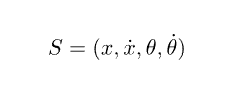
is continuous. This means that any of the state variables `x, \dot{x}, \theta, and \dot{\theta}` can take any value in the prescribed continuous intervals determined by the limits of the state space. Consequently, since the action value function Q(S,A) is a function of the state, this means that we have an infinite number of action-value functions. Consequently, it is practically impossible to store and update the value of Q(S,A).
What we want is actually a finite set of action values that can be updated. That is, we want to approximate a continuous state-space by a finite discrete state-space.



### Quantization or Discretization

To achieve that, we need to discretize each state variable. For example, let us assume that the state x can be in the interval [0,1]. Then, we can divide this interval into 4 segments:

- Segment 0 [0.25]
- Segment 1 (0.25,0.5]
- Segment 2 (0.5,0.75]
- Segment 3 (0.75,1]

The indices of segments start from 0, since we want to be consistent with the Python notation. Then, if for example, x=0.6, we can see that the x belongs to the segment 2. Consequently, we assign


x=0.6 -> 2

On the other hand, if x=0.213, we can see that this x belongs to the segment 0. Consequently, we assign

x=0.213 -> 0

We can perform this discretization for other state variables. In this way, we can assign to every continuous state 

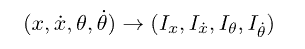


### Trying this shit now

In [54]:
position_space = np.linspace(-2.4, 2.4, 10)
velocity_space = np.linspace(-4, 4, 10)
angle_space = np.linspace(-0.21, 0.21, 10)
angular_velocity_space = np.linspace(-4, 4, 10)

In [55]:
Q_table = np.zeros((len(position_space)+1, len(velocity_space)+1, len(angle_space)+1, len(angular_velocity_space)+1, actions))

In [56]:
Q_table.shape

(11, 11, 11, 11, 2)

In [65]:
import torch

In [62]:
episode_durations = []

In [67]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [68]:
# Hyperparameters
alpha = 0.1
gamma = 0.99
episodes = 500
epsilon = 1.0
epsilon_decay = 0.999

for episode in tqdm(range(episodes)):
    state = env.reset()[0]
    state_p = np.digitize(state[0], position_space)
    state_v = np.digitize(state[1], velocity_space)
    state_a = np.digitize(state[2], angle_space)
    state_av = np.digitize(state[3], angular_velocity_space)

    terminated = False
    truncated = False

    score = 0

    while not terminated and not truncated:
        random_number = np.random.rand()
        if random_number < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state_p, state_v, state_a, state_av, :])

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state_p = np.digitize(next_state[0], position_space)
        next_state_v = np.digitize(next_state[1], velocity_space)
        next_state_a = np.digitize(next_state[2], angle_space)
        next_state_av = np.digitize(next_state[3], angular_velocity_space)
        done = terminated or truncated

        Q_table[state_p, state_v, state_a, state_av, action] = Q_table[state_p, state_v, state_a, state_av, action] + alpha * (reward + gamma * np.max(Q_table[next_state_p, next_state_v, next_state_a, next_state_av]) - Q_table[state_p, state_v, state_a, state_av, action])

        state = next_state
        state_p = next_state_p
        state_v = next_state_v
        state_a = next_state_a
        state_av = next_state_av

        score += reward

        if done:
            episode_durations.append(score)
            plot_durations()
            epsilon = max(0.1, epsilon-epsilon_decay)
            break

<Figure size 640x480 with 0 Axes>

In [44]:
state = env.reset()[0]
state_p = np.digitize(state[0], position_space)
state_v = np.digitize(state[1], velocity_space)
state_a = np.digitize(state[2], angle_space)
state_av = np.digitize(state[3], angular_velocity_space)

state_p, state_v, state_a, state_av

(5, 5, 5, 5)

[9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 9.0,
 10.0,
 10.0,
 10.0,
 16.0,
 8.0,
 8.0,
 9.0,
 9.0,
 8.0,
 9.0,
 13.0]